# Project: Stock Price Prediction with Walk-Forward Validation 

This notebook aims to predict the **Close**  price of the stock **AMD**  using historical daily data.

We follow a time series modeling approach using:
 
- Linear Regression
 
- Random Forest Regressor
 
- LSTM-DNN
 
- 1D-CNN-LSTM-DNN


#### Key Requirements 

 
- Data: [Kaggle Nasdaq Stock Dataset](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset)
 
- Target variable: `Close`
 
- Ticker: **AMD**
 
- Train/Test Split: **80/20**  by date
 
- Training Method: **Walk-forward validation**
 
- Evaluation: Plot predicted vs actual prices on test data



In [25]:
import numpy as np 
import pandas as pd 


# Dataset: loading and exploring

Date Range: 1980-03-17 to 2020-04-01
        Date  Open      High       Low     Close  Adj Close  Volume
0 1980-03-17   0.0  3.302083  3.125000  3.145833   3.145833  219600
1 1980-03-18   0.0  3.125000  2.937500  3.031250   3.031250  727200
2 1980-03-19   0.0  3.083333  3.020833  3.041667   3.041667  295200
3 1980-03-20   0.0  3.062500  3.010417  3.010417   3.010417  159600
4 1980-03-21   0.0  3.020833  2.906250  2.916667   2.916667  130800


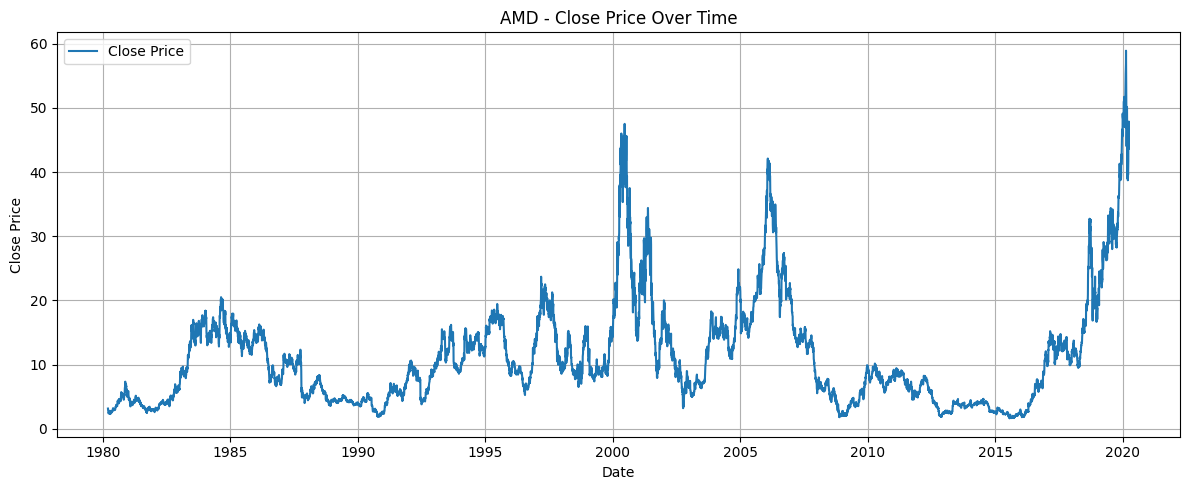

In [26]:
# STEP 1: Load and prepare AMD.csv

import pandas as pd
import matplotlib.pyplot as plt

# Load AMD stock data
df = pd.read_csv('/kaggle/input/stock-market-dataset/stocks/AMD.csv')

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date just in case
df = df.sort_values('Date').reset_index(drop=True)

# Basic info
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(df.head())

# Plot the closing prices
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('AMD - Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Data Preparation: Train/Test Split 


In this section, we:

 
- Split the time series into **train (80%)**  and **test (20%)**  subsets by date
 
- Prepare input features using lagged Close prices
 
- Set up the target variable as the current Close price

In [27]:
N_LAGS = 30

# Create lagged features before the split
def create_lagged_features(data, n_lags=N_LAGS):
    df_lagged = data.copy()
    for lag in range(1, n_lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged['Close'].shift(lag)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

df_lagged = create_lagged_features(df)

# Now do the train/test split
split_idx = int(len(df_lagged) * 0.8)
train_df = df_lagged.iloc[:split_idx].copy()
test_df = df_lagged.iloc[split_idx:].copy()

# Features and target
feature_cols = [f'lag_{i}' for i in range(1, N_LAGS + 1)]
X_train = train_df[feature_cols].values
y_train = train_df['Close'].values

X_test = test_df[feature_cols].values
y_test = test_df['Close'].values
dates_test = test_df['Date']  # for plotting later

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Train samples: 8054, Test samples: 2014


In [28]:
train_df["lag_1"]

0       2.729167
1       2.666667
2       2.552083
3       2.458333
4       2.468750
          ...   
8049    8.030000
8050    8.090000
8051    8.240000
8052    8.190000
8053    8.080000
Name: lag_1, Length: 8054, dtype: float64

# Linear Regression Benchmark

This section implements the **Linear Regression** model as a benchmark.

- The model uses lagged `Close` prices as input features.
- We apply **walk-forward validation** on the training set (first 80%) to simulate real-time prediction.
- The final evaluation is done on the **untouched 20% test set**.
- A plot comparing predicted and actual `Close` prices on the test set is generated.

Train RMSE (walk-forward, no leakage): 0.5241


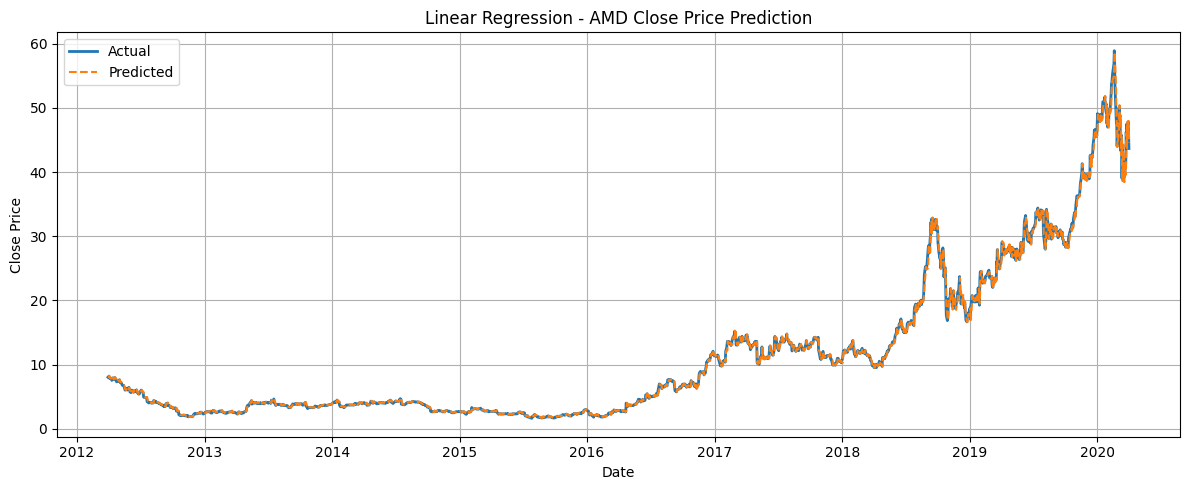

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Walk-forward validation on training set
preds_train = []
model = LinearRegression()

for i in range(1, len(X_train)):
    X_sub = X_train[:i]
    y_sub = y_train[:i]
    model.fit(X_sub, y_sub)
    y_pred = model.predict(X_train[i:i+1])
    preds_train.append(y_pred[0])

# Train RMSE (walk-forward)
train_rmse = mean_squared_error(y_train[1:], preds_train, squared=False)
print(f"Train RMSE (walk-forward, no leakage): {train_rmse:.4f}")

# Final model trained on full train set
model.fit(X_train, y_train)

# Predict on test set
y_pred_test = model.predict(X_test)

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_pred_test, label='Predicted', linestyle='--')
plt.title('Linear Regression - AMD Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest Regressor

This section implements the **Random Forest Regressor**.

- Input: lagged `Close` prices
- Training method: **Walk-forward validation** on training data (no leakage)
- Evaluation: Predict on the untouched **20% test set**
- Visualization: Plot actual vs predicted Close prices

Train RMSE (walk-forward, RF): 7.8415


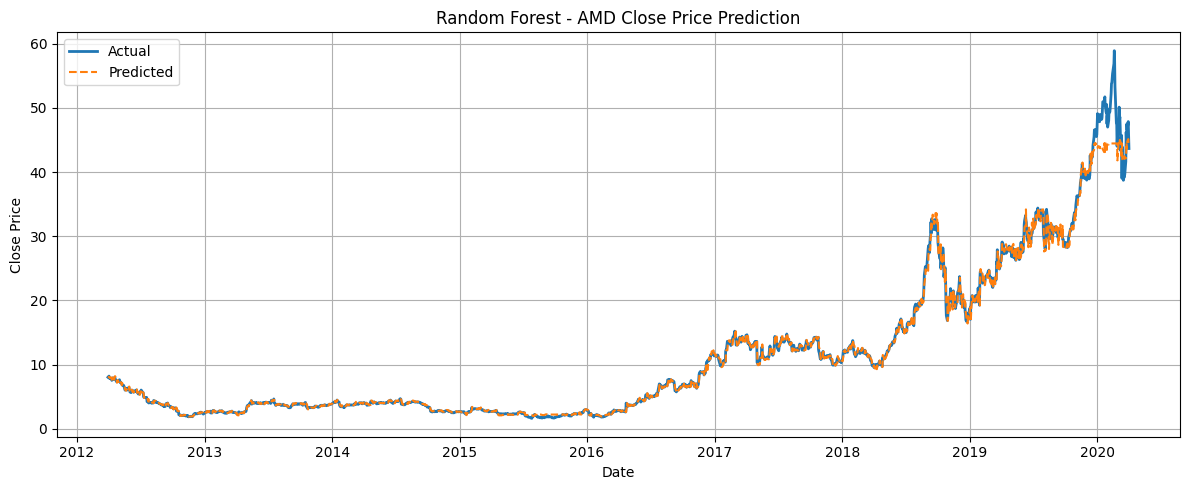

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_preds_train = []
rf_true_train = []

rf_model = RandomForestRegressor(n_estimators=25, random_state=42)

step = 5  # only update every 5 steps for speed

for i in range(40, len(X_train), step):
    X_sub = X_train[:i]
    y_sub = y_train[:i]
    rf_model.fit(X_sub, y_sub)
    
    for j in range(i, min(i + step, len(X_train))):
        rf_model.predict(X_train[j:j+1])[0]
        rf_preds_train.append(y_pred)
        rf_true_train.append(y_train[j])

# Walk-forward RMSE
rf_train_rmse = mean_squared_error(rf_true_train, rf_preds_train, squared=False)
print(f"Train RMSE (walk-forward, RF): {rf_train_rmse:.4f}")

# Final model on all training data
rf_model.fit(X_train, y_train)

# Test set predictions
y_rf_pred_test = rf_model.predict(X_test)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_rf_pred_test, label='Predicted', linestyle='--')
plt.title('Random Forest - AMD Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM-DNN Model (PyTorch)

This section implements the **LSTM-DNN** model using PyTorch for time series forecasting.

- Input: lagged `Close` prices reshaped into 3D (samples, timesteps, features)
- Walk-forward training applied on the training set (80%)
- Final evaluation on held-out test set (20%)

Walk-forward LSTM: 100%|██████████| 804/804 [20:06<00:00,  1.50s/it]


Train RMSE (walk-forward, LSTM, step=10): 5.2720


Final LSTM training: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


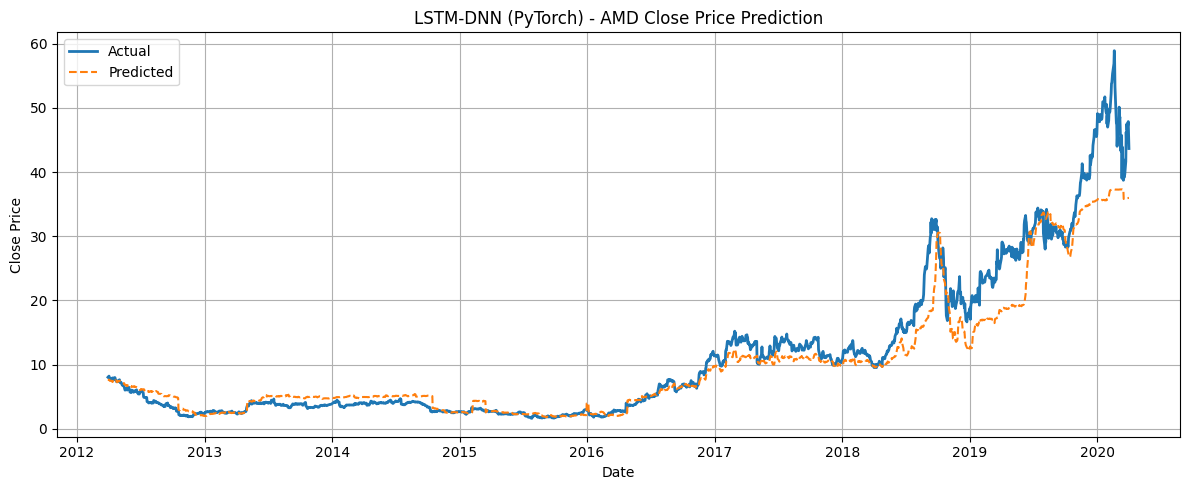

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use last time step
        return out

# Reshape data to (samples, timesteps, features)
def to_tensor_lstm(X, y):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (N, T, 1)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    return X_tensor.to(device), y_tensor.to(device)

# Convert your X_train, y_train, etc.
X_train_lstm, y_train_lstm = to_tensor_lstm(X_train, y_train)
X_test_lstm, y_test_lstm = to_tensor_lstm(X_test, y_test)

# Walk-forward training with step
lstm_preds_train = []
lstm_true_train = []

STEP = 10  # step size to reduce training loops

for i in tqdm(range(20, len(X_train), STEP), desc="Walk-forward LSTM"):
    model = LSTMModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train on first i samples
    X_sub = X_train_lstm[:i]
    y_sub = y_train_lstm[:i]
    dataset = TensorDataset(X_sub, y_sub)
    loader = DataLoader(dataset, batch_size=16, shuffle=False)

    model.train()
    for epoch in range(3):  # reduce for speed
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # Predict for the next few steps (up to STEP)
    model.eval()
    with torch.no_grad():
        for j in range(i, min(i + STEP, len(X_train))):
            pred = model(X_train_lstm[j:j+1]).item()
            lstm_preds_train.append(pred)
            lstm_true_train.append(y_train[j])

    # Free up GPU memory (optional but helpful for large loops)
    del model
    torch.cuda.empty_cache()

# Train RMSE
lstm_train_rmse = mean_squared_error(lstm_true_train, lstm_preds_train, squared=False)
print(f"Train RMSE (walk-forward, LSTM, step={STEP}): {lstm_train_rmse:.4f}")

# Final model trained on full training data
model_final = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

model_final.train()
for epoch in tqdm(range(20), desc="Final LSTM training"):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model_final(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

# Predict on test set
model_final.eval()
with torch.no_grad():
    y_lstm_pred_test = model_final(X_test_lstm).cpu().numpy().flatten()

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_lstm_pred_test, label='Predicted', linestyle='--')
plt.title('LSTM-DNN (PyTorch) - AMD Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 1D-CNN-LSTM-DNN Model (PyTorch)

This section implements a hybrid **1D-CNN + LSTM + DNN** model using PyTorch.

- The CNN layer captures local temporal patterns.
- The LSTM captures sequential dependencies over time.
- Final dense layer outputs the predicted Close price.
- Walk-forward training is used on the 80% train set.
- Evaluation is on the 20% held-out test set with a prediction plot.

Walk-forward CNN-LSTM: 100%|██████████| 804/804 [24:54<00:00,  1.86s/it]


Train RMSE (walk-forward, CNN-LSTM, step=10): 5.7156


Final CNN-LSTM Training: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


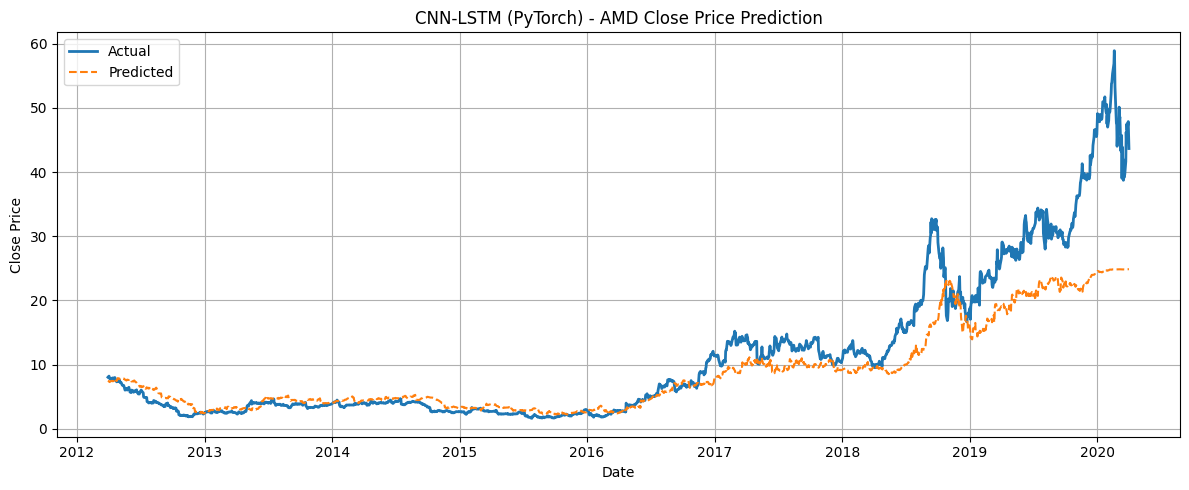

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size=1, cnn_channels=16, lstm_hidden=64):
        super(CNNLSTMModel, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=cnn_channels, kernel_size=2)
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_lstm_preds_train = []
cnn_lstm_true_train = []
STEP = 10

for i in tqdm(range(20, len(X_train), STEP), desc="Walk-forward CNN-LSTM"):
    model = CNNLSTMModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_sub = X_train_lstm[:i]
    y_sub = y_train_lstm[:i]
    loader = DataLoader(TensorDataset(X_sub, y_sub), batch_size=16, shuffle=False)

    model.train()
    for epoch in range(3):
        for xb, yb in loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        for j in range(i, min(i + STEP, len(X_train))):
            pred = model(X_train_lstm[j:j+1]).item()
            cnn_lstm_preds_train.append(pred)
            cnn_lstm_true_train.append(y_train[j])

    del model
    torch.cuda.empty_cache()

cnn_lstm_rmse = mean_squared_error(cnn_lstm_true_train, cnn_lstm_preds_train, squared=False)
print(f"Train RMSE (walk-forward, CNN-LSTM, step={STEP}): {cnn_lstm_rmse:.4f}")

final_cnn_lstm = CNNLSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_cnn_lstm.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(X_train_lstm, y_train_lstm), batch_size=16, shuffle=False)

final_cnn_lstm.train()
for epoch in tqdm(range(20), desc="Final CNN-LSTM Training"):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(final_cnn_lstm(xb), yb)
        loss.backward()
        optimizer.step()

final_cnn_lstm.eval()
with torch.no_grad():
    y_cnn_lstm_pred_test = final_cnn_lstm(X_test_lstm).cpu().numpy().flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_test, y_test, label='Actual', linewidth=2)
plt.plot(dates_test, y_cnn_lstm_pred_test, label='Predicted', linestyle='--')
plt.title('CNN-LSTM (PyTorch) - AMD Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Summary of Results

Below is a comparison of **walk-forward RMSE** on the training set and model predictions on the **untouched 20% test set** for all implemented models.

| Model                 | Walk-Forward Train RMSE | Notes                                 |
|----------------------|--------------------------|----------------------------------------|
| Linear Regression     | *0.5241*       | Baseline benchmark model               |
| Random Forest         | *7.8415*       | Captures nonlinear relationships       |
| LSTM-DNN (PyTorch)    | *5.2720*       | Sequential model with memory           |
| 1D-CNN-LSTM-DNN       | *5.7156*       | Combines local + sequential patterns   |

---

Each model was:

- Trained using **walk-forward validation** on the first 80% of the data
- Evaluated on the **last 20% test split** (no leakage)
- Plotted for predicted vs actual **Close** prices

This concludes the time series modeling for AMD stock prediction using multiple approaches.

In [33]:
# Final summary table
summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'LSTM-DNN', '1D-CNN-LSTM-DNN'],
    'Walk-Forward Train RMSE': [
        train_rmse,
        rf_train_rmse,
        lstm_train_rmse,
        cnn_lstm_rmse
    ]
})

print(summary)

               Model  Walk-Forward Train RMSE
0  Linear Regression                 0.524064
1      Random Forest                 7.841531
2           LSTM-DNN                 5.271977
3    1D-CNN-LSTM-DNN                 5.715601
